# Background 

## Executive summary of entire notebook


## Problem Statement 
Paste some news links here

explain different data sets


In [ ]:
# put in auto clicking thing
# remember to pep8

# function ClickConnect(){
#     console.log("Clicked on connect button"); 
#     document.querySelector("#ok").click()
# }
# setInterval(ClickConnect,60000)



# Import Libraries

In [1]:
import matplotlib.pyplot as plt

import numpy as np
from numpy import asarray

import seaborn as sns
import pandas as pd

from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix
from skimage import io

import os # this is to access the file system
import zipfile # this is to unzip if necessary
import shutil

from imutils import paths

import PIL 
from PIL import Image, ImageOps


import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Sequential
from keras.layers import Rescaling
from keras.preprocessing.image import ImageDataGenerator # for augmentation
from tensorflow.keras.applications.resnet50 import ResNet50 # transfer learning
from tensorflow.data import AUTOTUNE # for pipeline


pd.set_option("display.precision", 8)

In [1]:
# pre-trained models

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

# Pre-Processing

write some stuff here

## Create Directories

In [ ]:
# !unzip -q /content/drive/MyDrive/capstone/toupload.zip -d /content/drive/MyDrive/capstone/rawimage
# print('Import Complete.')

Import Complete.


In [2]:
# create variable for base path directory 

base_path = '/content/drive/MyDrive/capstone/datasets/'

# create variable for target_names
target_names = ['bluespotray', 'hybridgrouper', 'queenfish', 'redseabream', 'seabass', 'shovelnose']

In [6]:
# check number of unprocessed images inside folder 
unprocessed_path = base_path +'rawimage'
for x in target_names: 
  print(f"Unprocessed images in {x}: {len(os.listdir(os.path.join(unprocessed_path, x)))}")

Unprocessed images in bluespotray: 90
Unprocessed images in hybridgrouper: 72
Unprocessed images in queenfish: 155
Unprocessed images in redseabream: 1000
Unprocessed images in seabass: 1000
Unprocessed images in shovelnose: 157


In [14]:
# create function for clearing directories
def clear_dir(species, path_ext): #'root/'
  path = os.path.join(base_path, path_ext)
  all_files = os.listdir(os.path.join(path, species))
  for f in all_files:
    os.remove(os.path.join(path, species, f))

In [5]:
# clear directories
for x in target_names:
  clear_dir(x, 'root/')

# check number of images inside folder after cleaning
for x in target_names: 
  print(f"Number of images in {x}: {len(os.listdir(os.path.join(base_path, 'root/', x)))}")

Number of images in bluespotray: 0
Number of images in hybridgrouper: 0
Number of images in queenfish: 0
Number of images in redseabream: 0
Number of images in seabass: 0
Number of images in shovelnose: 0


## Image Resizing
Add padding to maintain aspect ratio

In [12]:
# write a function for image resizing

def resize(species): 
  
  for filename in os.listdir(os.path.join(base_path, 'rawimage/', species)):
    im = Image.open(os.path.join(base_path, 'rawimage/', species, filename))

    desired_size = 224

    old_size = im.size 
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    im = im.resize(new_size, Image.ANTIALIAS)

    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))  

  # save into a folder 
    path = os.path.join(base_path, 'root/', species)
    new_im.save(os.path.join(path,filename))

In [13]:
for x in target_names: 
  resize(x)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [14]:
# randomly check for size of images

im = Image.open('/content/drive/MyDrive/capstone/datasets/root/queenfish/talang_3.jpg')
im.size

(224, 224)

## Image Augmentation

Save augmented images to train folders, to create more datasets.

In [15]:
img_gen = ImageDataGenerator(
    zoom_range = 0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
)

In [16]:
def augment_pics(species, iterations): 
  dataset = []
  for filename in os.listdir(os.path.join(base_path, 'root/', species)):
    
    for i, image_name in enumerate(filename):  
      im = Image.open(os.path.join(base_path, 'root/', species, filename))
      dataset.append(np.array(im))
  x = np.array(dataset)

  i = 0

  for batch in img_gen.flow(x, batch_size=20,
                            save_to_dir=os.path.join(base_path, 'root/', species),
                            save_prefix='aug',
                            save_format='jpg'):
    i += 1
    if i > iterations:
      break

In [17]:
# not augmenting redseabream and seabass because there is enough data

augment_pics('bluespotray', 48)
augment_pics('hybridgrouper', 50)
augment_pics('shovelnose', 50)
augment_pics('queenfish', 50)

In [18]:
# check number of images inside folder after resizing and augmentation

for x in target_names: 
  print(f"Number of images in {x}: {len(os.listdir(os.path.join(base_path, 'root/', x)))}")

Number of images in bluespotray: 1062
Number of images in hybridgrouper: 1092
Number of images in queenfish: 1174
Number of images in redseabream: 1000
Number of images in seabass: 1000
Number of images in shovelnose: 1098


## Visualize Data for Model

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_path + 'root/', 
    image_size=(224, 224), 
    batch_size=20,
    seed=42
)

print(type(dataset))

Found 6426 files belonging to 6 classes.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [4]:
for data, labels in dataset.take(1):
    print(data.shape)
    print(labels.shape)

(20, 224, 224, 3)
(20,)


In [5]:
# create dictionary for classes

target_dict = {k: v for v, k in enumerate(dataset.class_names)}
target_dict

{'bluespotray': 0,
 'hybridgrouper': 1,
 'queenfish': 2,
 'redseabream': 3,
 'seabass': 4,
 'shovelnose': 5}

In [6]:
# convert class names to respective numeric values

target_val = [target_dict[dataset.class_names[i]] for i in range(len(dataset.class_names))]
target_val

[0, 1, 2, 3, 4, 5]

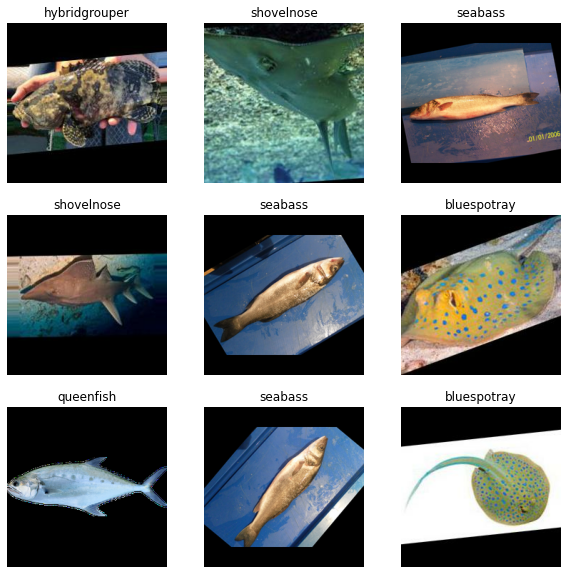

In [24]:
# visualize the data with augmented pictures

class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Build Pipeline

In [23]:
# create directories for split into train, test, val 
# for cls in target_names: 
#   os.makedirs(base_path + 'train/' + cls)
#   os.makedirs(base_path + 'validation/' + cls)
#   os.makedirs(base_path + 'test/' + cls)

In [20]:
for x in target_names:
  clear_dir(x, 'train/')
  clear_dir(x, 'test/')
  clear_dir(x, 'validation/')

for x in target_names: 
  print(f"Train images in {x}: {len(os.listdir(os.path.join(base_path, 'train/', x)))}")
  print(f"Test images in {x}: {len(os.listdir(os.path.join(base_path, 'test/', x)))}")
  print(f"Val images in {x}: {len(os.listdir(os.path.join(base_path, 'validation/', x)))}")
  print()
  print('------------------')

Train images in bluespotray: 0
Test images in bluespotray: 0
Val images in bluespotray: 0

------------------
Train images in hybridgrouper: 0
Test images in hybridgrouper: 0
Val images in hybridgrouper: 0

------------------
Train images in queenfish: 0
Test images in queenfish: 0
Val images in queenfish: 0

------------------
Train images in redseabream: 0
Test images in redseabream: 0
Val images in redseabream: 0

------------------
Train images in seabass: 0
Test images in seabass: 0
Val images in seabass: 0

------------------
Train images in shovelnose: 0
Test images in shovelnose: 0
Val images in shovelnose: 0

------------------


In [21]:
# decide split percentages 
train_split = 0.8
val_split = 0.1
test_split=0.1

# make directories to split root file images 
for cls in target_names: 
  src = base_path + 'root/' + cls # copy images from here
  allfiles = os.listdir(src)
  np.random.shuffle(allfiles)
  train_files, val_files, test_files = np.split(np.array(allfiles),
                                                [int(len(allfiles)*(1-(val_split+test_split))), 
                                                 int(len(allfiles)* (1-test_split))])

  train_files = [src + '/' + name for name in train_files.tolist()]

  val_files = [src + '/' + name for name in val_files.tolist()]

  test_files = [src + '/' + name for name in test_files.tolist()]

  print('Images for ', cls)
  print('Total images: ', len(allfiles))
  print('Training: ', len(train_files))
  print('Validation: ', len(val_files))
  print('Testing: ', len(test_files))
  print()
  


  # and paste images here
  for name in train_files:
    shutil.copy(name, (base_path +'train/' + cls))

  for name in val_files:
    shutil.copy(name, (base_path +'validation/' + cls))

  for name in test_files:
    shutil.copy(name, (base_path +'test/' + cls))

Images for  bluespotray
Total images:  1062
Training:  849
Validation:  106
Testing:  107

Images for  hybridgrouper
Total images:  1092
Training:  873
Validation:  109
Testing:  110

Images for  queenfish
Total images:  1174
Training:  939
Validation:  117
Testing:  118

Images for  redseabream
Total images:  1000
Training:  800
Validation:  100
Testing:  100

Images for  seabass
Total images:  1000
Training:  800
Validation:  100
Testing:  100

Images for  shovelnose
Total images:  1098
Training:  878
Validation:  110
Testing:  110



In [22]:
# check number of images in each folder 

for x in target_names: 
  print(f"Train images in {x}: {len(os.listdir(os.path.join(base_path, 'train/', x)))}")
  print(f"Test images in {x}: {len(os.listdir(os.path.join(base_path, 'test/', x)))}")
  print(f"Val images in {x}: {len(os.listdir(os.path.join(base_path, 'validation/', x)))}")
  print()
  print('------------------')

Train images in bluespotray: 849
Test images in bluespotray: 107
Val images in bluespotray: 106

------------------
Train images in hybridgrouper: 873
Test images in hybridgrouper: 110
Val images in hybridgrouper: 109

------------------
Train images in queenfish: 939
Test images in queenfish: 118
Val images in queenfish: 117

------------------
Train images in redseabream: 800
Test images in redseabream: 100
Val images in redseabream: 100

------------------
Train images in seabass: 800
Test images in seabass: 100
Val images in seabass: 100

------------------
Train images in shovelnose: 878
Test images in shovelnose: 110
Val images in shovelnose: 110

------------------


In [7]:
def config_perf(data): 
  AUTOTUNE = tf.data.AUTOTUNE
  data = data.cache()
  data = data.shuffle(1000) # shd this be length of all files 
  data = data.prefetch(buffer_size=AUTOTUNE)
  # data = data.batch(batch_size=20) putting this throws an error in image shape
  return data 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path + 'train/', 
    image_size=(224, 224), 
    batch_size=32,
    seed=42
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path + 'validation/', 
    image_size=(224, 224), 
    batch_size=32,
    seed=42
)

train_ds = config_perf(train_ds) 
val_ds = config_perf(val_ds)

Found 5139 files belonging to 6 classes.
Found 642 files belonging to 6 classes.


# Modelling - Base CNN

Summarize everything here. 

confusion matrix + accuracy scores. seems to classify everything as bluespotray

This Sequential model consists of 2 convolution blocks  with a max pooling layer in each of them. 

There's a fully-connected layer (tf.keras.layers.Dense) with 512num_classes=len(class_names units on top of it that is activated by a ReLU activation function ('relu').

### Model

In [7]:
# check pixel range is 0-255 before scaling
im = Image.open('/content/drive/MyDrive/capstone/datasets/train/hybridgrouper/hgrouper_10.jpg')
pixels = asarray(im)
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 0.000, Max: 255.000


In [8]:
model = models.Sequential()

# rescale layers
model.add(layers.Rescaling(1./255, input_shape=(224,224,3)))

# 1st convolution 
model.add(layers.Conv2D(512, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# 2nd convolution 
model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# 3rd convolution 
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# 4th convolution 
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# flatten into DNN 
model.add(layers.Flatten())

# fully connected nn with relu activation
model.add(layers.Dense(32, activation='relu'))

# 1 output neuron for 6 classes 
layers.Dense(6, activation='softmax')

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 512)     14336     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 512)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 256)     1179904   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       2

### Model Compilation

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
stepsize_train = (5139//20)-1 #how to use a formula to output length
stepsize_val = (642//20)-1

history = model.fit(
    train_ds, 
    # steps_per_epoch=stepsize_train,
    validation_data=val_ds,
    # validation_steps=stepsize_val,
    epochs=20
    )

Epoch 1/20


lol damn jialat

## Model Evaluation

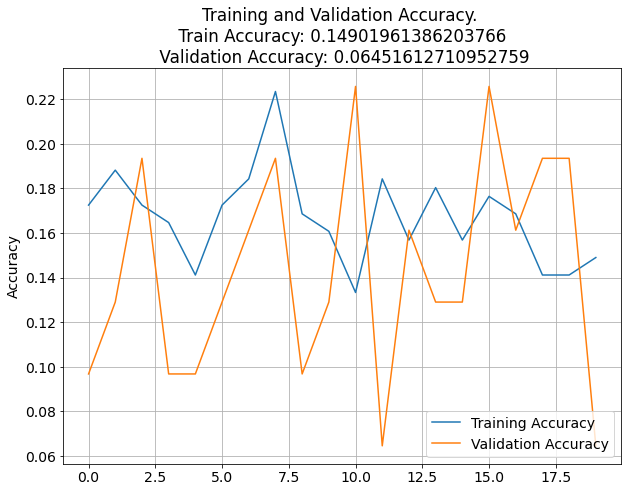

In [47]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
  
  
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'Training and Validation Accuracy. \n Train Accuracy: {str(acc[-1])} \n Validation Accuracy: {str(val_acc[-1])}')
plt.show()

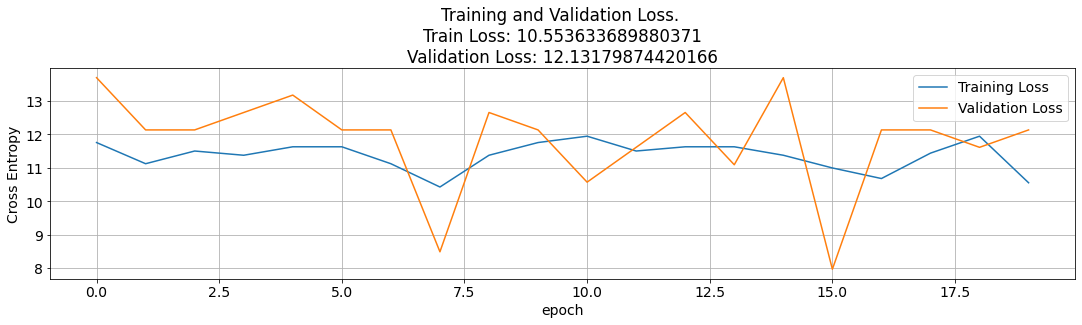

In [48]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [50]:
# plot confusion matrix?

Y_pred = model.predict_generator(val_ds, val_ds.n // val_ds.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_ds.classes, y_pred))
print('Classification Report')

print(classification_report(val_ds.classes, y_pred, target_names=target_names))

AttributeError: ignored

## Regularization

- Batch normalization 

- what on earth is globalaveragepooling2d

- early stopping

# set checkpoints and save best models


# Model Finetuning / transfer learning

In [ ]:
# resnet50 
# inceptionv3 
# efficientnet

# other models??? openimage google? 

# ensemble nn? am i crazy? 

## Feature Extraction

In [ ]:
# sobel to get outlines? 
# masking?

# Notes - future improvements

see if model can differentiate similar looking species of same scientific family 

would colour correction for photos help - adding red filter

how can i make my model say - this is not marine life eg. if i pass in a pic of a chair